# 📊 Predictive Modeling: Employee Absenteeism (Regression Analysis)


## 📦 1. Importing Libraries & Dataset

We begin by importing all necessary Python libraries for data manipulation, visualization, model building, and evaluation. These include `pandas`, `numpy`, `matplotlib`, `seaborn`, and key modules from `scikit-learn` and `xgboost`.

We load the cleaned dataset `Absenteeism_Cleaned.csv`, which includes engineered features and a log-transformed target variable (`Log_Absenteeism`) for better model performance.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb


In [27]:
df = pd.read_csv('../data/Absenteeism_Cleaned.csv') 

In [28]:
df.head()

,Month Value,Day of the Week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pet,Absenteeism Time in Hours,Reason_Group,Log_Absenteeism
0,7,1,289,36,33,239.554,30,0,2,1,4,4,1.609438
1,7,1,118,13,50,239.554,31,0,1,0,0,0,0.000000
2,7,2,179,51,38,239.554,31,0,0,0,2,4,1.098612
3,7,3,279,5,39,239.554,24,0,2,0,4,1,1.609438
4,7,3,289,36,33,239.554,30,0,2,1,2,4,1.098612


## 📌 Define Features & Target
We select relevant numerical and categorical features that may influence absenteeism.  
The target variable is `'Absenteeism Time in Hours'`, which we aim to predict.


In [29]:
features = [
    'Reason_Group', 'Month Value', 'Day of the Week', 'Transportation Expense',
    'Distance to Work', 'Age', 'Daily Work Load Average',
    'Body Mass Index', 'Education', 'Children', 'Pet'
]

target = 'Absenteeism Time in Hours'

X = df[features]
y = df[target]

## 🔀 Train-Test Split
We split the dataset into training (80%) and testing (20%) sets to evaluate model performance fairly.


In [30]:
from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shapes
X_train.shape, X_test.shape

((560, 11), (140, 11))

## 📈 Train Linear Regression Model
We begin with a baseline Linear Regression model to understand linear relationships between features and absenteeism.


In [31]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

## 📊 Evaluate Linear Regression Model

We use R² (coefficient of determination) and RMSE (Root Mean Squared Error) to assess model performance.

- **R² Score:** Indicates the proportion of variance explained by the model.  
- **RMSE:** Measures average prediction error in the original units.

The plot compares actual vs predicted absenteeism to visually assess model fit.


In [32]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")

R² Score: 0.06
RMSE: 12.11


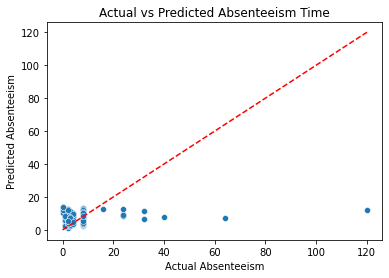

In [33]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Absenteeism")
plt.ylabel("Predicted Absenteeism")
plt.title("Actual vs Predicted Absenteeism Time")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.show()

## 🌲 Random Forest Regression & Feature Insights

We now train a Random Forest Regressor on the log-transformed absenteeism hours to improve performance.

- **Model Training:** Uses 100 decision trees with fixed random state.
- **Evaluation:** Assessed with R² and RMSE on both log scale and original hour units.
- **Performance:** Shows significant improvement over linear regression.
- **Feature Importance:** Visualized to understand which variables drive absenteeism predictions.

Key takeaway: The Random Forest model captures more complex patterns and highlights impactful features like `Reason_Group` and `Daily Work Load Average`.


In [13]:
df['Log_Absenteeism'] = np.log1p(df['Absenteeism Time in Hours'])

# Redefine target for this model
y_log = df['Log_Absenteeism']

In [14]:
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)


In [15]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)

y_pred_log = rf.predict(X_test)

r2 = r2_score(y_test_log, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_log))

print(f"Random Forest R²: {r2:.2f}")
print(f"Random Forest RMSE (log scale): {rmse:.2f}")

Random Forest R²: 0.46
Random Forest RMSE (log scale): 0.60


In [16]:
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"Random Forest RMSE (original hours): {rmse_original:.2f}")

Random Forest RMSE (original hours): 11.24


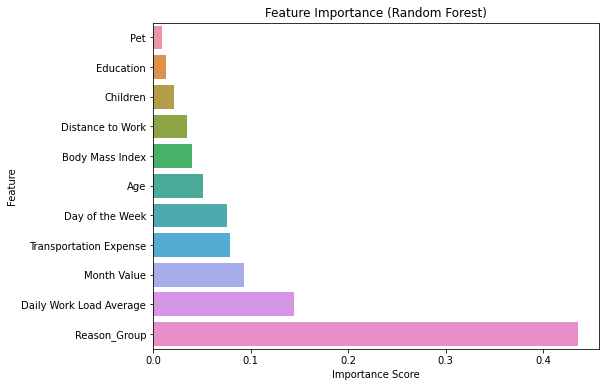

In [17]:
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## ⚡ XGBoost Regression & Feature Insights

We apply the XGBoost Regressor to model absenteeism using log-transformed targets for better distribution.

- **Training Setup:** 100 estimators, learning rate of 0.1, with random state for reproducibility.
- **Evaluation:** Compared on R² and RMSE, both in log scale and original hours.
- **Performance:** Performs competitively with Random Forest, suggesting consistent accuracy.
- **Feature Importance:** Highlights the top predictive drivers such as `Reason_Group`, `Education`, and `Transportation Expense`.

XGBoost provides strong predictive power with fast execution, and helps identify the most influential factors behind employee absenteeism.


In [18]:
import sys
!{sys.executable} -m pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [20]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

xgb.fit(X_train, y_train_log)

y_pred_xgb_log = xgb.predict(X_test)

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

r2_xgb = r2_score(y_test_log, y_pred_xgb_log)
rmse_xgb_log = np.sqrt(mean_squared_error(y_test_log, y_pred_xgb_log))

y_pred_xgb_original = np.expm1(y_pred_xgb_log)
y_test_original = np.expm1(y_test_log)
rmse_xgb_original = np.sqrt(mean_squared_error(y_test_original, y_pred_xgb_original))

print(f"XGBoost R² (log): {r2_xgb:.2f}")
print(f"XGBoost RMSE (log): {rmse_xgb_log:.2f}")
print(f"XGBoost RMSE (original hours): {rmse_xgb_original:.2f}")

XGBoost R² (log): 0.42
XGBoost RMSE (log): 0.63
XGBoost RMSE (original hours): 11.83


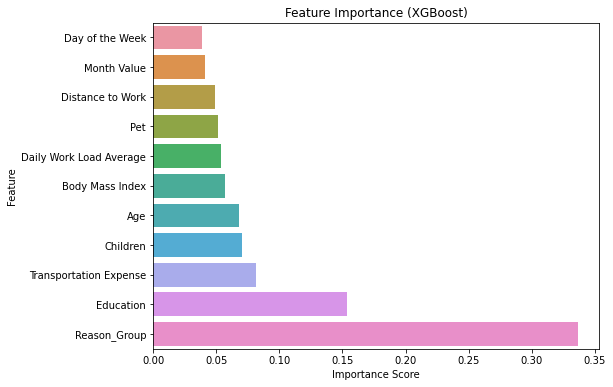

In [23]:
xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(x=xgb_importance, y=xgb_importance.index)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## 💾 Export Data for Tableau Dashboard

We select the most relevant columns for visualization and save the cleaned dataset as a `.csv` file for Tableau.

- Focused on key features like `Reason_Group`, `Month`, `Education`, `Children`, `Pet`, etc.
- Ensures a structured and interpretable dataset for building interactive dashboards.

📁 Output file: `Absenteeism_for_Tableau.csv`


In [24]:
# Columns to keep for Tableau
tableau_df = df[[
    'Reason_Group', 'Month Value', 'Day of the Week', 'Transportation Expense',
    'Distance to Work', 'Age', 'Daily Work Load Average',
    'Body Mass Index', 'Education', 'Children', 'Pet',
    'Absenteeism Time in Hours'
]]

# Save to CSV
tableau_df.to_csv('Absenteeism_for_Tableau.csv', index=False)